# Andrew Ng's Machine Learning MOOC: Week 8: K-Means Clustering & Principal Component Analysis

# Programming Exercise 7

## 0. Introduction
This notebook contains my solutions to the programming exercise for week 8 of Andrew Ng's famous Machine Learning MOOC on Coursera (https://www.coursera.org/learn/machine-learning).

This week, we will implement the k-means clustering algorithm to compress an image. We will use Principal Component Analysis (PCA) to find a low-dimensional representation of face images.

Now, the course requires submission of programming exercises in either the MATLAB or OCTAVE programming language.
However since:
- I already code in Python for various web development and data science projects, and
- Python is the pre-eminent language currently used in data science and machine learning (and MATLAB and OCTAVE don't seem to be used anywhere near as much)
I decided it would be more valuable to me to use Python to complete the programming exercises.

I was therefore very pleased to find the following source, which has kindly written a set of python scripts to allow one to create Python implementations of the programming exercises for the course, and still submit them for scoring by the MOOC: https://github.com/dibgerge/ml-coursera-python-assignments

Thanks very much `dibgerge!`

In addition to the course's own lecture materials, I also used a number of other sources to help me solve the programming exercises. These include:

#### Other courses I've completed:
- Harvard's *Using Python for Research* on edX: https://www.edx.org/course/using-python-for-research
- UC San Diego's *Python for Data Science*, also on edX: https://www.edx.org/course/python-for-data-science-2
- MIT's *Introduction to Computational Thinking and Data Science I and II*, also on edX: https://www.edx.org/course/introduction-to-computational-thinking-and-data-4
- Imperial College London's *Mathematics for Machine Learning I-III* on Coursera: https://www.coursera.org/specializations/mathematics-machine-learning
- Goldsmith's / University of London's *Foundations of Data Science: K-means Clustering in Python* on Coursera: https://www.coursera.org/learn/data-science-k-means-clustering-python

#### Books:
- Python Machine Learning by Sebastian Raschka and Vahid Mirjalili: https://sebastianraschka.com/books.html

#### Blogs and websites
I found this blog a very useful reference:
https://www.johnwittenauer.net/machine-learning-exercises-in-python-part-7/

This blog by `hadrienj` also provides a nice discussion of covariance matrices - what they are and how to calculate them:
https://hadrienj.github.io/posts/Preprocessing-for-deep-learning/
(see his github here: https://github.com/hadrienj/Preprocessing-for-deep-learning)

And of course, there's always StackOverflow!

One thing that struck me, looking at all of these different resources, is how many different ways there are to implement basically the same code in python, even using numpy and pandas dataframes! And that's before we think about object-oriented implementations, or using libraries such as scikitlearn.

OK, now that the introduction is complete, let's get started with some imports. You can find instructions on how to install required libraries in the README file in `dibgerge`'s github repository.

In [1]:
# used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np

# Import regular expressions to process emails
import re

# Plotting library
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import seaborn as sns
sns.set() # set seaborn as default plotting style

from IPython.display import HTML, display, clear_output

try:
    plt.rcParams["animation.html"] = "jshtml"
except ValueError:
    plt.rcParams["animation.html"] = "html5"

# Optimization module in scipy
from scipy import optimize

# will be used to load MATLAB mat datafile format
from scipy.io import loadmat

# used to calculate euclidean distance between vectors in numpy
from scipy.spatial import distance

# time library - used to create time-stamps for operations
import time

# library written for this exercise providing additional functions for assignment submission, and others
import utils

# define the submission/grader object for this exercise
grader = utils.Grader()

# tells matplotlib to embed plots within the notebook
%matplotlib inline

## 1 K-means Clustering

In this exercise, we will implement the K-means algorithm and use it for image compression. We'll start with an example 2D image to help develop our intuition for how the K-means algorithm works. After that, we'll use the K-means algorithm for image compression by reducing the number of colors that occur in an image to only those that are most common in that image.

### 1.1 Implementing K-means

The K-means algorithm is a method to automatically cluster similar data examples together. Concretely, we are given a training set:

$$\{x^{(1)} , \cdots, x^{(m)}\}  (where $x^{(i)} \in \mathbb{R}^n)$$

and want to group the data into a few cohesive “clusters”.

K-means is an iterative procedure that starts by guessing the initial centroids, and then refines this guess by repeatedly assigning examples to their closest centroids and then recomputing the centroids based on the assignments.

In `Python` pseudocode, the K-means algorithm can be written as follows:

```python
centroids = kMeansInitCentroids(X, K)
for i in range(iterations):
    # Cluster assignment step: Assign each data point to the
    # closest centroid. idx[i] corresponds to cˆ(i), the index
    # of the centroid assigned to example i
    idx = findClosestCentroids(X, centroids)
    
    # Move centroid step: Compute means based on centroid
    # assignments
    centroids = computeMeans(X, idx, K)
```

The inner-loop of the algorithm repeatedly carries out two steps:

(1) Assigning each training example $x^{(i)}$ to its closest centroid; and

(2) Recomputing the mean of each centroid using the points assigned to it.

The K-means algorithm will always converge to some final set of means for the centroids. Note, however, that the converged solution may not always be ideal - i.e. the algorithm may converge onto a local minimum, rather than the global minimum) - and depends on the initial setting of the centroids. Therefore, in practice the K-means algorithm is usually multiple a few times with different random initializations. We can then choose the solution with the lowest cost function value. 

We are going to implement the two phases of the K-means algorithm separately in the next sections.

After we've done that, we'll also implement it in `scikitlearn`, for "real-world" practice.

#### 1.1.1 Finding closest centroids

In the “cluster assignment” step of the K-means algorithm, the algorithm assigns every training example $x^{(i)}$ to its closest centroid, given the current positions of centroids.

Specifically, for every example $i$ we set:

$$c^{(i)} := j \quad \text{that minimizes} \quad \lvert\rvert x^{(i)} - \mu_j  \lvert\rvert^2, $$

where
- $c^{(i)}$ is the index of the centroid that is closest to $x^{(i)}$
- $\mu_j$ is the position (value) of the $j^{th}$ centroid.

Note that $c^{(i)}$ corresponds to `idx[i]` in the starter code.

Our first task is to complete the code in the function `findClosestCentroids`. This function takes the data matrix `X` and the locations of all centroids inside `centroids` and should output a one-dimensional array `idx` that holds the index (a value in $\{1, ..., K\}$, where $K$ is total number of centroids) of the closest centroid to every training example.

In [2]:
def findClosestCentroids(X, centroids):
    """
    Computes the centroid memberships for every example.
    
    Parameters
    ----------
    X : array_like
        The dataset of size (m, n) where each row is a single example. 
        That is, we have m examples each of n dimensions.
        
    centroids : array_like
        The k-means centroids of size (K, n). K is the number
        of clusters, and n is the the data dimension.
    
    Returns
    -------
    idx : array_like
        A vector of size (m, ) which holds the centroids assignment for each
        example (row) in the dataset X.
        idx[i] contains the index of the centroid closest to example i.
        Hence, it must be a value in the range 0..K-1
    """
    # Determine value of K
    K = centroids.shape[0]

    # Initialize idx
    idx = np.zeros(X.shape[0], dtype=int)
 
    # Loop over number of rows in X
    for row in range(X.shape[0]):
        squared_distances = []
        # Loop over centroids
        for centroid in range(K):
            squared_distance = distance.euclidean(X[row], centroids[centroid])**2
            squared_distances.append(squared_distance)
        centroid_assigned = squared_distances.index(min(squared_distances))
        idx[row] = centroid_assigned
    
    return idx

We can now test our implementation of `findClosestCentroids()` on a test case. We should see the output `[0 2 1]` corresponding to the centroid assignments for the first 3 examples in `X`.

In [3]:
# Load example dataset
data = loadmat(os.path.join('Data', 'ex7data2.mat'))
X = data['X']

# Select an initial set of centroids
K = 3   # 3 Centroids
initial_centroids = np.array([[3, 3], [6, 2], [8, 5]])

# Find the closest centroids for the examples using the initial_centroids
idx = findClosestCentroids(X, initial_centroids)

print('Closest centroids for the first 3 examples:')
print(idx[:3])
print('(the closest centroids should be 0, 2, 1 respectively)')

Closest centroids for the first 3 examples:
[0 2 1]
(the closest centroids should be 0, 2, 1 respectively)


### 1.1.2 Computing centroid means

The second step of the K-means algorithm is as follows: given the assignment of every point to a centroid, we now recompute, for each centroid, the mean of the points that were assigned to it.

Specifically, for every centroid $k$ we set

$$ \mu_k := \frac{1}{\left| C_k\right|} \sum_{i \in C_k} x^{(i)}$$

where $C_k$ is the set of examples that are assigned to centroid $k$. Concretely, if two examples say $x^{(3)}$ and $x^{(5)}$ are assigned to centroid $k = 2$, then you should update $\mu_2 = \frac{1}{2} \left( x^{(3)} + x^{(5)} \right)$.

You should now complete the code in the function `computeCentroids`. You can implement this function using a loop over the centroids. You can also use a loop over the examples; but if you can use a vectorized implementation that does not use such a loop, your code may run faster.
<a id="computeCentroids"></a>

In [4]:
def computeCentroids(X, idx, K):
    """
    Returns the new centroids by computing the means of the data points
    assigned to each centroid.
    
    Parameters
    ----------
    X : array_like
        The datset where each row is a single data point. That is, it 
        is a matrix of size (m, n) where there are m datapoints each
        having n dimensions. 
    
    idx : array_like 
        A vector (size m) of centroid assignments (i.e. each entry in range [0 ... K-1])
        for each example.
    
    K : int
        Number of clusters
    
    Returns
    -------
    centroids : array_like
        A matrix of size (K, n) where each row is the mean of the data 
        points assigned to it.
    
    Instructions
    ------------
    Go over every centroid and compute mean of all points that
    belong to it. Concretely, the row vector centroids[i, :]
    should contain the mean of the data points assigned to
    cluster i.

    Note:
    -----
    You can use a for-loop over the centroids to compute this.
    """
    # Initialize some useful variables
    m, n = X.shape

    # Initialize centroids array
    centroids = np.zeros((K, n))

    # For each centroid
    for centroid in range(K):
        # find_indices of data-points that are assigned to that centroid
        centroid_indices = np.argwhere(idx == centroid)
        # select sub-set of data-points in X that are assigned to that centroid
        assigned_data_points = X[centroid_indices]
        # calculate mean for these data-points (column-wise, so axis = 0)
        centroids[centroid] = np.mean(assigned_data_points, axis = 0)
    
    return centroids

We can test our implementation of `computeCentroids()` using the following test-case supplied by the course - which will run our code and output the centroids after the first step of K-means:

In [5]:
# Compute means based on the closest centroids found in the previous part.
centroids = computeCentroids(X, idx, K)

print('Centroids computed after initial finding of closest centroids:')
print(centroids)
print('\nThe centroids should be')
print('   [ 2.428301 3.157924 ]')
print('   [ 5.813503 2.633656 ]')
print('   [ 7.119387 3.616684 ]')

Centroids computed after initial finding of closest centroids:
[[ 2.42830111  3.15792418]
 [ 5.81350331  2.63365645]
 [ 7.11938687  3.6166844 ]]

The centroids should be
   [ 2.428301 3.157924 ]
   [ 5.813503 2.633656 ]
   [ 7.119387 3.616684 ]


### 1.2 K-means on an example dataset 

Now we've completed the two functions `findClosestCentroids()` and `computeCentroids()`, we have all the necessary pieces to run the K-means algorithm. `dibgerge` kindly wrote a function to run the K-means algorithm for us (it's `runKmeans()`, supplied in the `utils` file. However, I'm not going to use it, because
- It's supposed to produce a nice animation showing what happens on each iteration of the K-means algorithm - but unfortunately, I don't appear to have all of the libraries installed to make the animation work; and
- Anyway, it's instructive, and simple, to write out the function here.

So instead I've written out my own function, and then I'm going to produce a static chart of the outcome.

In [6]:
def run_k_means(X, initial_centroids, max_iters):
    """
    This function runs the K-means algorithm
    
    Parameters
    ----------
    X : array_like 
        The dataset of size (m x n).
    
    initial_centroids: array_like
                       The initial centroids from which
                       to begin the K-means algorithm
    
    max_iters : int
        The maximum number of iterations for the algorithm
    
    Returns
    -------
    idx: array_like
        The index of the cluster to which each data-point
        in X is classified by the algorithm
        This is an array of size (m,)
    
    centroids : array_like
        Centroids of the clusters. This is a matrix of size (K x n).
    """
    m, n = X.shape
    k = initial_centroids.shape[0]
    idx = np.zeros(m)
    centroids = initial_centroids
    
    for i in range(max_iters):
        idx = findClosestCentroids(X, centroids)
        centroids = computeCentroids(X, idx, k)
    
    return idx, centroids

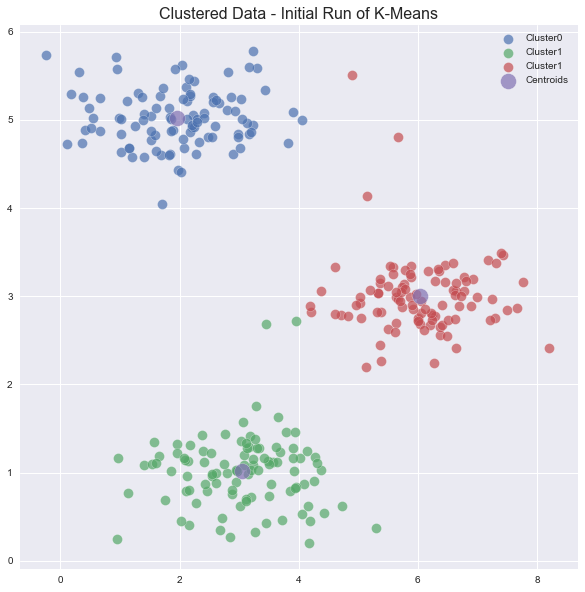

In [7]:
# Settings for running K-Means
K = 3
max_iters = 10

# For consistency, here we set centroids to specific values
# ...but in practice we'd want to generate them automatically, such as by
# setting them to be random examples
initial_centroids = np.array([[3, 3], [6, 2], [8, 5]])

# Run K-Means algorithm
idx, centroids = run_k_means(X, initial_centroids, max_iters)

# Now we're going to plot a static chart of the final outcome
# Select each group from X, based on final assigment to centroids
group0 = X[np.where(idx == 0)[0],:]
group1 = X[np.where(idx == 1)[0],:]
group2 = X[np.where(idx == 2)[0],:]

# Plot static chart
fix, ax = plt.subplots(figsize = (10, 10))
ax.scatter(group0[:,0], group0[:,1], s = 100, alpha = 0.7, edgecolor="white", label = "Cluster0")
ax.scatter(group1[:,0], group1[:,1], s = 100, alpha = 0.7, edgecolor="white", label = "Cluster1")
ax.scatter(group2[:,0], group2[:,1], s = 100, alpha = 0.7, edgecolor="white", label = "Cluster1")
ax.scatter(centroids[:,0], centroids[:,1], s = 250, alpha = 0.7, edgecolor="white", label = "Centroids")
ax.legend()
ax.set_title("Clustered Data - Initial Run of K-Means", fontsize = 16)

### 1.3 Random initialization 

**Remember**, the centroids that result from K-means depend on the positions chosen for the initial centroids.

In the example above, we chose [were given] specific centroids so that we could test that our result looked like the chart above (hey, congrats - we did it!).

In practice, a good strategy for initializing the centroids is to select random examples from the training set.

Below we complete the function `kMeansInitCentroids()` to randomly select $K$ data points as our initial centroids, using the following code:

```python
# Initialize the centroids to be random examples

# Randomly reorder the indices of examples
randidx = np.random.permutation(X.shape[0])
# Take the first K examples as centroids
centroids = X[randidx[:K], :]
```

This code first randomly permutes the indices of the examples (using the `permute()` method within the `numpy.random` module) - we can think of this as, randomly shuffling the indices of the data points. Then, it selects the first $K$ examples of the randomly-premuted indices. In this way we are able to select the initial centroids at random without the risk of selecting the same example twice.

In [8]:
def kMeansInitCentroids(X, K):
    """
    This function initializes K centroids that are to be used in K-means on the dataset x.
    
    Parameters
    ----------
    X : array_like 
        The dataset of size (m x n).
    
    K : int
        The number of clusters.
    
    Returns
    -------
    centroids : array_like
        Centroids of the clusters. This is a matrix of size (K x n).
    """
    # determine some useful values
    m, n = X.shape
    
    # initialize an array to hold the centroids
    centroids = np.zeros((K, n))
    
    # randomly reorder the indices of examples
    # see https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.random.permutation.html
    randidx = np.random.permutation(X.shape[0]) 
    # take the first K examples as centroids
    centroids = X[randidx[:K], :]
    
    return centroids

If we run the cell below multiple times, we should see that each time we do so, it randomly chooses a different set of $K$ data points to be our initial centroids:

In [9]:
kMeansInitCentroids(X, 3)

array([[ 3.2670134 ,  0.32056676],
       [ 6.27376271,  2.24256036],
       [ 2.17777173,  4.86154019]])

### 1.4 Image compression with K-means

In this exercise, we will apply K-means as a mechanism for image compression. We will use the image below as an example (property of Frank Wouters with permission to this class).

![](Data/bird_small.png)

In a straightforward 24-bit color representation of an image, each pixel is represented as three 8-bit unsigned integers (ranging from 0 to 255) that specify the red, green and blue intensity values. This encoding is often referred to as the RGB encoding. Our image contains thousands of colors, and in this part of the exercise, you will reduce the number of colors to 16 colors.

By making this reduction, it is possible to represent (compress) the photo in an efficient way. Specifically, you only need to store the RGB values of the 16 selected colors, and for each pixel in the image you now need to only store the index of the color at that location (where only 4 bits are necessary to represent 16 possibilities).

We will use the K-means algorithm to select the 16 colors that will be used to represent the compressed image. Specifically, we will treat every pixel in the original image as a data example and use the K-means algorithm to find the 16 colors that best group (cluster) the pixels in the 3-dimensional RGB space. Once we have computed the cluster centroids on the image, we will use the 16 colors to replace the pixels in the original image.

In python, images can be read in as follows:

```python
# Load 128x128 color image (bird_small.png)
img = mpl.image.imread(os.path.join('Data', 'bird_small.png'))

# We have already imported matplotlib as mpl at the beginning of this notebook.
```
This creates a three-dimensional matrix `A` whose first two indices identify a pixel position and whose last index represents red, green, or blue. For example, A[50, 33, 2] gives the blue intensity of the pixel at row 51 and column 34 (where rows and columns of the pixels are indexed from 1, rather than being 0-indexed).

The code in the following cell first loads the image, and then reshapes it to create an m x 3 matrix of pixel colors (where m = 16384 = 128 x 128), and calls your K-means function on it.

After finding the top K = 16 colors to represent the image, we can now assign each pixel position to its closest centroid using the `findClosestCentroids` function. This allows us to represent the original image using the centroid assignments of each pixel. Notice that we have significantly reduced the number of bits that are required to describe the image. The original image required 24 bits for each one of the 128 x 128 pixel locations, resulting in total size of 128 x 128 x 24 = 393,216 bits. The new representation requires some overhead storage in form of a dictionary of 16 colors, each of which require 24 bits, but the image itself then only requires 4 bits per pixel location. The final number of bits used is therefore (16 x 24) + (128 x 128 x 4) = 65,920 bits, which corresponds to compressing the original image by about a factor of 6.

Finally, we can view the effects of the compression by reconstructing the image based only on the centroid assignments. Specifically, we can replace each pixel location with the mean of the centroid assigned to it.

The code in the cell below will compute the centroids and the centroid classification of each pixel in the image, and then displays the original and compressed images. The resulting image should retain most of the characteristics of the original (depending on what values we give for K and the number of iterations of the K-means algorithm); nonetheless, we should expect to see some compression artifacts - i.e. some loss of information due to the compression.

Completed the function in 58.0062 seconds


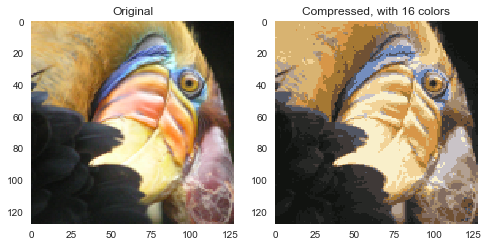

In [10]:
# ======= Experiment with these parameters ================
# You should try different values for those parameters
K = 16
max_iters = 10

# Load an image of a bird
# Change the file name and path to experiment with your own images
A = mpl.image.imread(os.path.join('Data', 'bird_small.png'))
# ==========================================================

# Divide by 255 so that all values are in the range 0 - 1
A /= 255

# Reshape the image into an Nx3 matrix where N = number of pixels.
# Each row will contain the Red, Green and Blue pixel values
# This gives us our dataset matrix A_prime that we will use K-Means on.
A_prime = A.reshape(-1, 3)

# Create time-stamp for beginning of K-Means algorithm
tick = time.perf_counter()

# When using K-Means, it is important to randomly initialize centroids
# You should complete the code in kMeansInitCentroids above before proceeding
initial_centroids = kMeansInitCentroids(A_prime, K)

# Run K-Means
idx, centroids = run_k_means(A_prime, initial_centroids, max_iters)

# create time-stamp for end of K-Means algorithm 
tock = time.perf_counter()
print("Completed the function in {:0.4f} seconds".format(tock - tick))

# We can now recover the image from the indices (idx) by mapping each pixel
# (specified by its index in idx) to the centroid value
# Reshape the recovered image into proper dimensions
A_prime_recovered = centroids[idx, :].reshape(A.shape)

# Display the original image, rescale back by 255
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(A*255)
ax[0].set_title('Original')
ax[0].grid(False)

# Display compressed image, rescale back by 255
ax[1].imshow(A_prime_recovered*255)
ax[1].set_title('Compressed, with %d colors' % K)
ax[1].grid(False)

So, that took around 40 seconds (it varies a little each time this is run) - quite slow!

We could also run this algorithm on our own images - simply change the file-path to the image. 

Note, however, that if our image is very large, then K-means can take a long time to run. It's therefore a good idea to resize images to manageable sizes before running the code.

### 1.5 K-Means with `scikitlearn`

Now let's run our k-means algorithm using the implementation from the `sciikitlearn` ML library.

First, we'll need to run a few of additional import statements:

In [11]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from matplotlib import patches as patches

#### 1.5.1 Let's start with our data-set from section 1.1 above.

Our first step is to normalize our data (so that all its dimensions are centred around a mean of 0) and then and scale it by the standard deviation. We can do this in one line using `scikitlearn`'s `StandardScaler()` module:

In [12]:
# note we're using our original 'data' variable from the very
# ...top of the notebook, and looking at its 'X' variables...
X_scaled = StandardScaler().fit_transform(data['X'])

Now we run K-means over our scaled data using `scikitlearn`'s implementation. Again, we can do this in one line:

In [13]:
kmeans = KMeans(n_clusters=3).fit(X_scaled)

One really interesting thing to **note** here is that *we don't have to pass in any initial positions for the centroids*. `scikitlearn`'s implementation automatically chooses random centroids for us. In fact, it does something a little more sophisticated than that - it's default setting is to use the `k-means++` algorithm, which not only chooses k centroids for us, but chooses them such that they are each far away from each other - reducing the likelihood that the algorithm will converge to (i.e. get stuck in) a local minumum - pretty handy!

If we now want to look at the centroids, or the classification of data points, we can do that by calling some of the attributes of our fitted KMneans object:

In [14]:
# cluster centroids
kmeans.cluster_centers_

array([[-0.88471375,  1.21462826],
       [ 1.21726404, -0.00858381],
       [-0.33801725, -1.1820774 ]])

In [15]:
# resulting labels / classification index
kmeans.labels_

array([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0], d

And we can plot a chart of this analysis - which should look very similar to our previous version except that (i) the data are scaled; and (ii) we're going to add ellipses covering 1-standard deviation either side of the centroids (because - well, why not?)

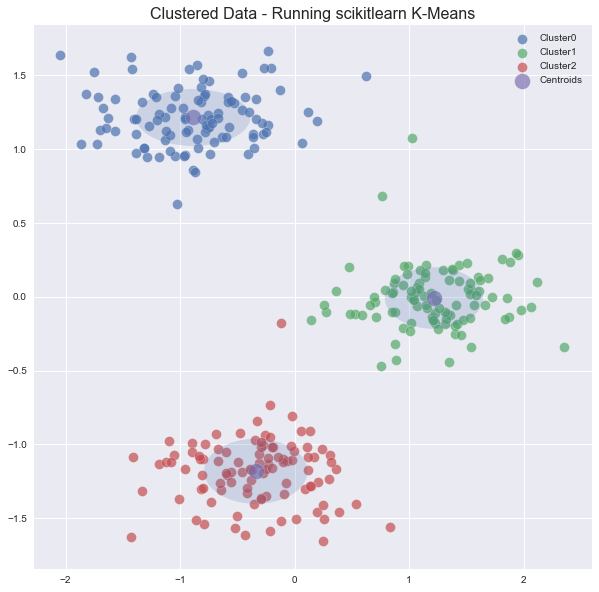

In [16]:
# Now we're going to plot a static chart of the final outcome

# Select each group from X_scaled, based on final assigment to centroids
group0 = X_scaled[np.where(kmeans.labels_ == 0)[0],:]
group1 = X_scaled[np.where(kmeans.labels_ == 1)[0],:]
group2 = X_scaled[np.where(kmeans.labels_ == 2)[0],:]

# Define ellipses by reference to standard deviation of assigned data points
group0_sd1 = np.std(group0[:, 0], ddof=1)
group0_sd2 = np.std(group0[:, 1], ddof=1)
group1_sd1 = np.std(group1[:, 0], ddof=1)
group1_sd2 = np.std(group1[:, 1], ddof=1)
group2_sd1 = np.std(group2[:, 0], ddof=1)
group2_sd2 = np.std(group2[:, 1], ddof=1)

ellipse_0 = patches.Ellipse([kmeans.cluster_centers_[0][0], kmeans.cluster_centers_[0][1]], (group0_sd1*2), (group0_sd2*2), alpha = 0.2)
ellipse_1 = patches.Ellipse([kmeans.cluster_centers_[1][0], kmeans.cluster_centers_[1][1]], (group1_sd1*2), (group1_sd2*2), alpha = 0.2)
ellipse_2 = patches.Ellipse([kmeans.cluster_centers_[2][0], kmeans.cluster_centers_[2][1]], (group2_sd1*2), (group2_sd2*2), alpha = 0.2)

# Plot static chart
fix, ax = plt.subplots(figsize = (10, 10))
ax.scatter(group0[:,0], group0[:,1], s = 100, alpha = 0.7, edgecolor="white", label = "Cluster0")
ax.scatter(group1[:,0], group1[:,1], s = 100, alpha = 0.7, edgecolor="white", label = "Cluster1")
ax.scatter(group2[:,0], group2[:,1], s = 100, alpha = 0.7, edgecolor="white", label = "Cluster2")
ax.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], s = 250, alpha = 0.7, edgecolor="white", label = "Centroids")
ax.add_patch(ellipse_0)
ax.add_patch(ellipse_1)
ax.add_patch(ellipse_2)
ax.legend()
ax.set_title("Clustered Data - Running scikitlearn K-Means", fontsize = 16)

#### 1.5.2 Using `scikitlearn` for our image compression task

Again, this is done in just a few lines, this time calling `scikitlearn`'s `kMeans()` module on the image data, which we loaded and re-shaped into `A_prime` above.

In [17]:
# feature scaling
ss = StandardScaler()
A_prime_scaled = ss.fit_transform(A_prime)

# Create time-stamp for beginning of K-Means algorithm
tick = time.perf_counter()

# instantiate the kMeans object
kmeans = KMeans(n_clusters=16).fit(A_prime_scaled)

# create time-stamp for end of K-Means algorithm 
tock = time.perf_counter()
print("Completed the function in {:0.4f} seconds".format(tock - tick))

Completed the function in 1.5389 seconds


So, that took about 1 second - around 40 times faster than our own algorithm! That's why we use libraries like `scikitlearn` in production, everyone!

In [18]:
# extract the centroids of the clusters
centroids = kmeans.cluster_centers_

In [19]:
# extract the labels of each data point of the clusters
idx = kmeans.labels_

Now we can recover the image just as before.

First, let's take a look at how **NOT** to do it:

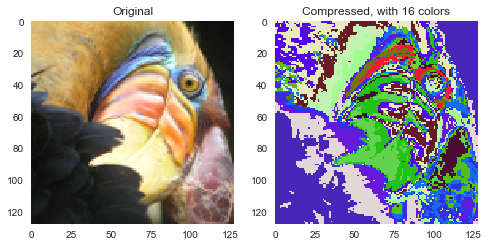

In [20]:
# Reshape the recovered image into proper dimensions
A_prime_recovered = centroids[idx, :].reshape(A.shape)

# Display the original image, rescale back by 255
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(A*255)
ax[0].set_title('Original')
ax[0].grid(False)

# Display compressed image, rescale back by 255
ax[1].imshow(A_prime_recovered*255)
ax[1].set_title('Compressed, with %d colors' % K)
ax[1].grid(False)

OK, that looks kind of cool...but it's really not what we were looking for!

What's going on is that we have created the image using our *scaled* data - specifically, referring to the scaled values of the centroids that our K-Means algorithm has identified.

If we want to create our compressed image using our original colour-scheme, then we need to convert the output we got for our centroids to the original feature dimensions. This is very easy to do with `scikitlearn`:

In [21]:
centroids_unscaled = ss.inverse_transform(centroids)

We can now recover the image from the indices (`idx`) by mapping each pixel to the new colour - defined in centroids_unscaled - specified by that pixel's index in `idx`.

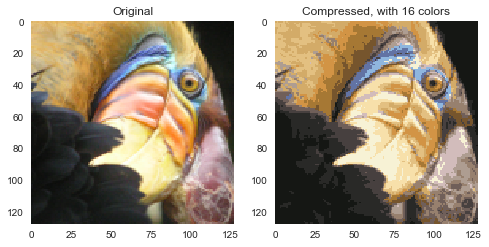

In [22]:
# Reshape the recovered image into proper dimensions
A_prime_recovered2 = centroids_unscaled[idx, :].reshape(A.shape)

# Display the original image, rescale back by 255
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(A*255)
ax[0].set_title('Original')
ax[0].grid(False)

# Display compressed image, rescale back by 255
ax[1].imshow(A_prime_recovered2*255)
ax[1].set_title('Compressed, with %d colors' % K)
ax[1].grid(False)

Now let's move on to Principal Component Analysis

## 2 Principal Component Analysis

In this exercise, we will use principal component analysis (PCA) to perform dimensionality reduction. We'll start with an example 2D dataset to develop our intuition on how PCA works; then we'll use it on a larger 5000 face image dataset.

### 2.1 Example Dataset

To help us understand how PCA works, we'll start with a 2D dataset which has one direction of large variation and one of smaller variation. We will visualize what happens when we use PCA to reduce the data from 2D to 1D. In practice, we're more likely to be reducing data from, say 256 to 50 dimensions; but using lower dimensional data in this example allows us to visualize the algorithms better so we can see what's going on.

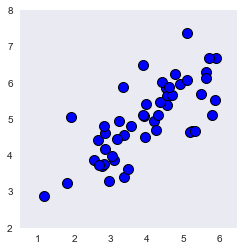

In [23]:
# Load the dataset into the variable X 
data = loadmat(os.path.join('Data', 'ex7data1.mat'))
X = data['X']

#  Visualize the example dataset
plt.plot(X[:, 0], X[:, 1], 'bo', ms=10, mec='k', mew=1)
plt.axis([0.5, 6.5, 2, 8])
plt.gca().set_aspect('equal')
plt.grid(False)

### 2.2 Implementing PCA

In this part of the exercise, we will implement PCA.

PCA consists of two computational steps: 

1. Compute the covariance matrix of the data.
2. Compute the eigenvectors $U_1$, $U_2$, $\dots$, $U_n$ using a technique called "Singular Vector Decomposition" (SVD). These will correspond to the principal components of variation in the data. We are initially going to use `numpy`'s implementation `np.linalg.svd` to do this. Later we'll take both steps using `scikitlearn`. 

First, we need to compute the covariance matrix of the data, which is given by:

$$ \Sigma = \frac{1}{m} X^T X$$

where $X$ is the data matrix with examples in rows, and $m$ is the number of examples.

Note that $\Sigma$ is an $n \times n$ matrix and **not** the summation operator. 

After computing the covariance matrix, we can run SVD on it to compute the principal components. In `Python` and `numpy` (or `scipy`), we can run SVD with the following command: `U, S, V = np.linalg.svd(Sigma)`, where `U` will contain the principal components and `S` will contain a diagonal matrix representing the proportion of the total variance that is captured by each eigenvector. Note that the `scipy` library also has a similar function to compute SVD `scipy.linalg.svd`. The functions in the two libraries use the same C-based library (LAPACK) for the SVD computation, but the `scipy` version provides more options and arguments to control SVD computation. In this exercise, we will stick with the `numpy` implementation of SVD; later we'll use `scikitlearn`'s implemetation.

Our task is to complete the code in the function `pca()` below, to implement PCA.

In [24]:
def pca(X):
    """
    Run principal component analysis.
    
    Parameters
    ----------
    X : array_like
        The dataset to be used for computing PCA. It has dimensions (m x n)
        where m is the number of examples (observations) and n is 
        the number of features. It MUST already be normalized.
    
    Returns
    -------
    U : array_like
        The eigenvectors, representing the computed principal components
        of X. U has dimensions (n x n) where each column is a single 
        principal component.
    
    S : array_like
        A vector of size n, contaning the singular values for each
        principal component. Note this is the diagonal of the matrix we 
        mentioned in class.
    """
    # Determine some useful values
    m, n = X.shape
    
    # Step1 - calculate covariance matrix - relies on X having already been normalised
    Covariance_Matrix =  X.T.dot(X) / m
    
    # Step2 - compute the eigenvectors using SVD
    U, S, V = np.linalg.svd(Covariance_Matrix)
    
    return U, S

Before using PCA, it is important to first normalize the data by subtracting the mean value of each feature from the dataset, and scaling each dimension so that they are in the same range.

We will do this in the next cell using the `utils.featureNormalize` function provided for us by the course and translated into `Python` for us by `dibgerge`.

After normalizing the data, we will then run PCA to compute the principal components - which should look something like this:

![](Figures/pca_components.png)

We will also output the "top" eigenvector (i.e. the one that explains the greatest proportion of the total variance). This should be an output of about `[-0.707 -0.707]`.

**Note** that it's possible that `numpy` may instead output the negative of this, since $U_1$ and $-U_1$ are equally valid choices for the first principal component.




Top eigenvector: U[:, 0] = [-0.707107 -0.707107]
 (you should expect to see [-0.707107 -0.707107])


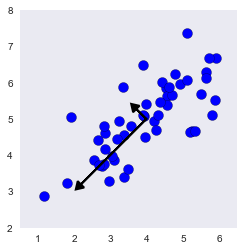

In [25]:
#  Before running PCA, it is important to first normalize X
X_norm, mu, sigma = utils.featureNormalize(X)

#  Run PCA
U, S = pca(X_norm)

#  Draw the eigenvectors centered at mean of data. These lines show the
#  directions of maximum variations in the dataset.
fig, ax = plt.subplots()
ax.plot(X[:, 0], X[:, 1], 'bo', ms=10, mec='k', mew=0.25)

for i in range(2):
    ax.arrow(mu[0], mu[1], 1.5 * S[i]*U[0, i], 1.5 * S[i]*U[1, i],
             head_width=0.25, head_length=0.2, fc='k', ec='k', lw=2, zorder=1000)

ax.axis([0.5, 6.5, 2, 8])
ax.set_aspect('equal')
ax.grid(False)

print('Top eigenvector: U[:, 0] = [{:.6f} {:.6f}]'.format(U[0, 0], U[1, 0]))
print(' (you should expect to see [-0.707107 -0.707107])')

**Note** in general, I'm a little unhappy with how we've calculated the covariance matrix in our `pca()` function above.
- For one thing, it only works because we already input normalized data.
- For another, I'd rather use methods from the robust and fast `numpy` module, that write my own functions.

And in fact, numpy does contain `numpy.cov()` method to calculate covariance matrices - see: https://docs.scipy.org/doc/numpy/reference/generated/numpy.cov.html

Let's take a look at what it would do if we asked it to calculate the covariance matrix of X_norm:

In [26]:
Cov_Matrix_NP = np.cov(X_norm.T, bias = True)
print(Cov_Matrix_NP)

[[ 0.98        0.72081977]
 [ 0.72081977  0.98      ]]


And let's now run SVD on this covariance matrix and pull out the first eigenvector:

In [27]:
U, S, V = np.linalg.svd(Cov_Matrix_NP)
print(U[0, 0], U[1, 0])

-0.707106781187 -0.707106781187


These are the *same* results as our "hand-written" function outputs (with the small exception that the output is shown as two numbers, rather than in an array.

Nonetheless, using the `numpy.cov()` method doesn't pass the course's grader, so didn't use it.

Before we move on, let's also visualize the data and the covariance matrix of X_norm - using some nice code from the blog post by `hadrienj` that I linked to at the top of the notebook:

In [28]:
def plotDataAndCov(data):
    """
    Calculate the covariance matrix of an input array 'data'
    and plots it, alont with the data itself
    
    Parameters
    ----------
    data: array-like
          the input data
          
    Returns
    -------
    None
    """

    ACov = np.cov(data, rowvar=False, bias=True)
    print('Covariance matrix:\n', ACov)

    fig, ax = plt.subplots(nrows=1, ncols=2)
    fig.set_size_inches(10, 10)

    ax0 = plt.subplot(2, 2, 1)

    # Choosing the colors
    cmap = sns.cubehelix_palette(8, start=.5, rot=-.75, as_cmap=True)
    sns.heatmap(ACov, cmap=cmap, vmin=0)

    ax1 = plt.subplot(2, 2, 2)

    # data can include the colors
    if data.shape[1]==3:
        c=data[:,2]
    else:
        c="#0A98BE"
    ax1.scatter(data[:,0], data[:,1], c=c, s=40)

    # Remove the top and right axes from the data plot
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)

Now let's use this function on our X_norm data:

Covariance matrix:
 [[ 0.98        0.72081977]
 [ 0.72081977  0.98      ]]


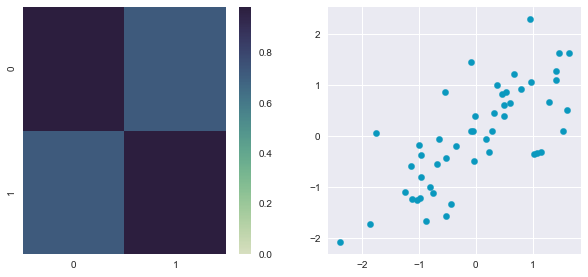

In [29]:
plotDataAndCov(X_norm)
plt.show()

### 2.3 Dimensionality Reduction with PCA

After computing the principal components, we can use them to reduce the feature dimension of our dataset by projecting each example onto a lower dimensional space, $x^{(i)} \rightarrow z^{(i)}$ (e.g., projecting the data from 2D to 1D). In this part of the exercise, we will use the eigenvectors returned by our `pca()` function and project the example dataset into a 1-dimensional space.

In "real-life" practice, if we were using a learning algorithm such as linear regression, support vector machines, or perhaps neural networks, we could now use the projected data instead of the original data. By using the projected data, we will be able to train our model faster as there are less dimensions in the input.

#### 2.3.1 Projecting the data onto the principal components

Our task is now to complete the code in the function `projectData()`. Specifically, we are given a dataset `X`, the principal components `U`, and the desired number of dimensions to reduce to `K`. We should project each example in `X` onto the top `K` components in `U`. We do this by creating a matrix of eigenvectors, `Ureduce` that contains the top `K` components in `U`. These are represented in the first `K` columns of `U`, that is, `Ureduce = U[:, :K]`.

Before we go any further, let's just sense-check we've got the right shape for `U`

In [30]:
U.shape

(2, 2)

In [31]:
def projectData(X, U, K):
    """
    Computes the reduced data representation when projecting only 
    on to the top K eigenvectors.
    
    Parameters
    ----------
    X : array_like
        The input dataset of shape (m x n). The dataset is assumed to be 
        normalized.
    
    U : array_like
        The computed eigenvectors using PCA. This is a matrix of 
        shape (n x n). Each column in the matrix represents a single
        eigenvector (or a single principal component).
    
    K : int
        Number of dimensions to project onto. Must be smaller than n.
    
    Returns
    -------
    Z : array_like
        The projects of the dataset onto the top K eigenvectors. 
        This will be a matrix of shape (m x k).
    """
    # Initialize an array to hold our output, Z
    Z = np.zeros((X.shape[0], K))
    
    # Extract relevant eigenvectors from U
    U_reduced = U[:,:K]
   
    # Project X onto relevant eigenvectors
    Z = np.dot(X, U_reduced)
    
    return Z

Once you have completed the code in `projectData`, the following cell will project the first example onto the first dimension and you should see a value of about 1.481 (or possibly -1.481, if you got $-U_1$ instead of $U_1$).

In [33]:
#  Project the data onto K = 1 dimension
K = 1
Z = projectData(X_norm, U, K)
print('Projection of the first example: {:.6f}'.format(Z[0, 0]))
print('(this value should be about    : 1.481274)')

Projection of the first example: 1.481274
(this value should be about    : 1.481274)


#### 2.3.2 Reconstructing an approximation of the data

After projecting the data onto the lower dimensional space, we can *approximately* recover the data by projecting them back onto the original high dimensional space. We do this by simply reversing the steps we took to project the data onto our lower-dimensional sub-space.

Our task in this part of the exercise is to complete the function `recoverData()` to project each example in `Z` back onto the original space and return the recovered approximation in `Xrec`.

In [34]:
def recoverData(Z, U, K):
    """
    Recovers an approximation of the original data when using the 
    projected data.
    
    Parameters
    ----------
    Z : array_like
        The reduced data after applying PCA. This is a matrix
        of shape (m x K).
    
    U : array_like
        The eigenvectors (principal components) computed by PCA.
        This is a matrix of shape (n x n) where each column represents
        a single eigenvector.
    
    K : int
        The number of principal components retained
        (should be less than n).
    
    Returns
    -------
    X_rec : array_like
        The recovered data after transformation back to the original 
        dataset space. This is a matrix of shape (m x n), where m is 
        the number of examples and n is the dimensions (number of
        features) of original datatset.
    """
    # Initialise a numpy array to hold our return value
    X_rec = np.zeros((Z.shape[0], U.shape[0]))

    # Calculate X_rec by projecting Z back onto space spanned...
    # ...by original basis vectors, using U_reduced
    U_reduced = U[:,:K]
    X_rec = np.dot(Z, U_reduced.T)
    
    return X_rec

We can now apply this function to our reduced data set, Z, and recover an approximation of the first example we looked at (which should be a value of about `[-1.047 -1.047]`):

In [35]:
X_rec  = recoverData(Z, U, K)
print('Approximation of the first example: [{:.6f} {:.6f}]'.format(X_rec[0, 0], X_rec[0, 1]))
print('       (this value should be about  [-1.047419 -1.047419])')

Approximation of the first example: [-1.047419 -1.047419]
       (this value should be about  [-1.047419 -1.047419])


If we then plot this data  - see below - we can compare the original data (in blue) with the reduced data set *projected back* onto the original space (in red). The *recovered* projection effectively retains only the information in the direction given by $U_1$. The dotted lines show the distance from the data points in original space to the projected space. Those dotted lines represent the error measure due to PCA projection. Hopefully this provides a good illustration of how PCA works.

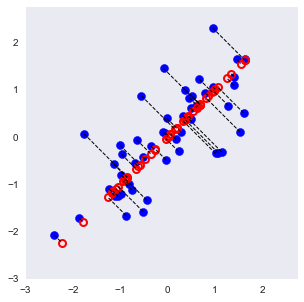

In [36]:
#  Plot the normalized dataset (returned from featureNormalize)
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(X_norm[:, 0], X_norm[:, 1], 'bo', ms=8, mec='b', mew=0.5)
ax.set_aspect('equal')
ax.grid(False)
plt.axis([-3, 2.75, -3, 2.75])

# Draw lines connecting the projected points to the original points
ax.plot(X_rec[:, 0], X_rec[:, 1], 'ro', mec='r', mew=2, mfc='none')
for xnorm, xrec in zip(X_norm, X_rec):
    ax.plot([xnorm[0], xrec[0]], [xnorm[1], xrec[1]], '--k', lw=1)

### 2.4 Face Image Dataset

Now we've learned how to do PCA on an example dataset, it's time to run it on a real, large-dimensional data set to see how it can be used in practice for dimension reduction.

The dataset `ex7faces.mat` contains a dataset `X` of face images, each $32 \times 32$ in grayscale. This dataset was based on a [cropped version](http://conradsanderson.id.au/lfwcrop/) of the [labeled faces in the wild](http://vis-www.cs.umass.edu/lfw/) dataset. Each row of `X` corresponds to one face image - i.e. a row vector of length 1024 (32 x 32).

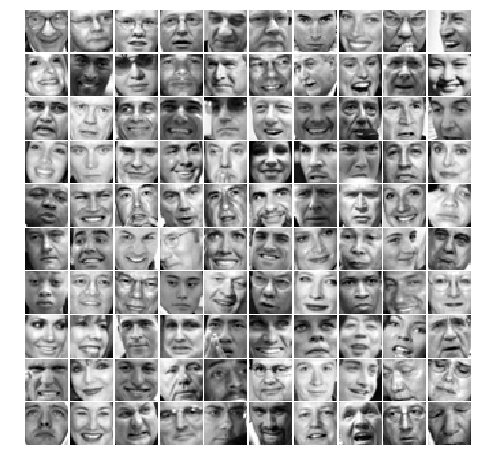

In [37]:
#  Load Face dataset
data = loadmat(os.path.join('Data', 'ex7faces.mat'))
X = data['X']

#  Display the first 100 faces in the dataset
utils.displayData(X[:100, :], figsize=(8, 8))

#### 2.4.1 PCA on Faces

To run PCA on the face dataset, we first normalize the dataset by subtracting the mean of each feature from the data matrix `X`.  After running PCA, you will obtain the principal components of the dataset. Notice that each principal component in `U` (each column) is a vector of length $n$ (where for the face dataset, $n = 1024$).

It turns out that we can visualize these principal components by reshaping each of them into a $32 \times 32$ matrix that corresponds to the pixels in the original dataset. 

We're going to do this once using our own functions, and then again using `scikitlearn`.

Starting with our own functions, the next cell will normalize the dataset and then run our PCA code. It will then show the first 36 principal components (conveniently called eigenfaces) that describe the largest amount of variation. Feel free to change the code to display more principal components to see how they capture more and more details.

Completed the `pca()` function in 0.3766 seconds


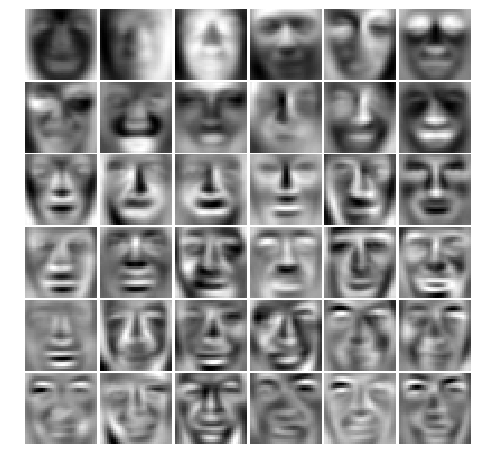

In [38]:
# normalize X by subtracting the mean value from each feature
X_norm, mu, sigma = utils.featureNormalize(X)

# Create time-stamp for beginning of K-Means algorithm
tick = time.perf_counter()

# run PCA
U, S = pca(X_norm)

# create time-stamp for end of K-Means algorithm 
tock = time.perf_counter()
print("Completed the `pca()` function in {:0.4f} seconds".format(tock - tick))

# visualize the top 36 eigenvectors found
utils.displayData(U[:, :36].T, figsize=(8, 8))

#### 2.4.2 Dimensionality Reduction

Now that we've computed the principal components for the face dataset, we can use it to reduce the dimension of the face dataset. This allows us to use our learning algorithm with a smaller input size (e.g., 100 dimensions) instead of the original 1024 dimensions. This can help speed up oour learning algorithm.

The next cell will project the face dataset onto only the first 100 principal components. Concretely, each face image is now described by a vector $z^{(i)} \in \mathbb{R}^{100}$. To understand what is lost in the dimension reduction, you can recover the data using only the projected dataset.

In [39]:
#  Project images to the eigen space using the top k eigenvectors 
#  If you are applying a machine learning algorithm 
K = 100
Z = projectData(X_norm, U, K)

print('The projected data Z has a shape of: ', Z.shape)

The projected data Z has a shape of:  (5000, 100)


In the next cell, an approximate recovery of the data is performed and the original and projected face images
are displayed:

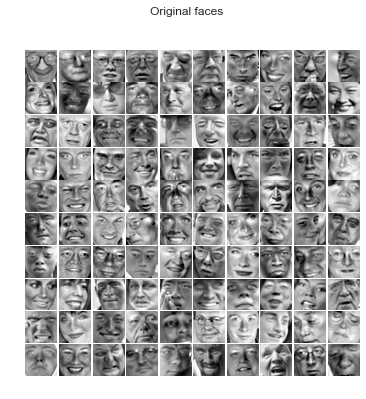

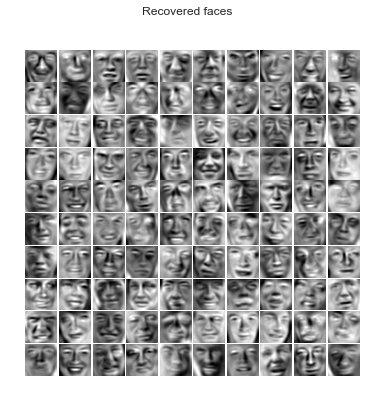

In [41]:
#  Project images to the eigenspace using the top K eigenvectors and 
#  visualize only using those K dimensions
#  Compare to the original input, which is also displayed
K = 100
X_rec  = recoverData(Z, U, K)

# Display normalized data
utils.displayData(X_norm[:100, :], figsize=(6, 6))
plt.gcf().suptitle('Original faces')

# Display reconstructed data from only k eigenfaces
utils.displayData(X_rec[:100, :], figsize=(6, 6))
plt.gcf().suptitle('Recovered faces')
pass

We can see that the general structure and appearance of the face are kept in the reconstruction, while the fine details are lost. This is a remarkable reduction (more than 10x) in the dataset size that can help speed up the learning algorithm significantly. For example, if you were training a neural network to perform person recognition (given a face image, predict the identity of the person), we could use the dimension reduced input of only  100 dimensions instead of the original 1,024.

<div class="alert alert-block alert-warning">
<span style="color: red; font-size: 150%; font-weight: bold">Important Note on Ethics</span>
<p>
In the example mentioned above of training a neural network to perform facial recognition, we'd **want to think carefully about the ethical implications of this *before we even started***.

We might want to think about, for example:
<ul>
<li>**Why** are we doing this?</li>
<li>**Who** is going to use this technology?</li>
<li>**What* are they going to do with it? Is this purpose ethical?</li>
<li>**What biases** are built into the data - and how will this affect the outcomes for different (groups of) people? Is there any way we can remove these biases? If not, what do we do?</li>
<li>**What measures and institutions** are in place to challenge and/or correct the use of the technology and data? Are these robust?</li>
<li>etc.</li>
</ul>
</p>
</div>

### 2.5 Using `scikitlearn`'s implementation of PCA

Now we will use `scikitlearn`'s implementation of PCA to reduce the dimensions of the same faces data set.

First we'll import the required modules:

In [42]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

Just to avoid any confusion, I'm going to load the faces data once more:

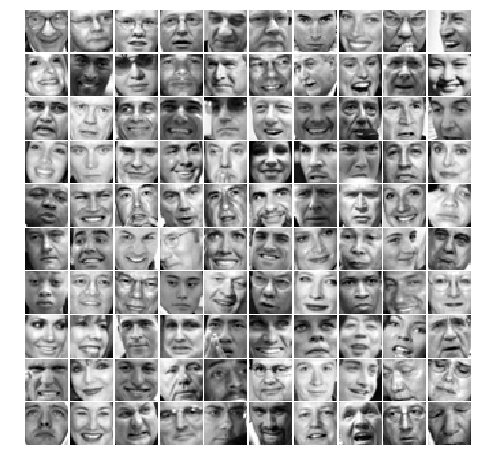

In [43]:
#  Load Face dataset
data = loadmat(os.path.join('Data', 'ex7faces.mat'))
faces = data['X']

#  Display the first 100 faces in the dataset
utils.displayData(faces[:100, :], figsize=(8, 8))

Now let's use `scikitlearn`'s `StandardScaler()` object to normalize our faces data:

In [44]:
scaler = StandardScaler()
faces_norm = scaler.fit_transform(faces)

Then let's run PCA on this data. Note that we set the `n_components` parameter to be 0.8, which has the effect of extracting the *n* eigenvectors that account for 80% of the variance.

In practice, we'd be likely to set this to 95% - but I want to be able to illustrate the effect projecting our reduced-dimensional sub-space back onto the original basis vectors - and to do that we need to have a reasonably material degradation of information, otherwise the photos would look the same!

In [45]:
# Create time-stamp for beginning of K-Means algorithm
tick = time.perf_counter()

# Run PCA using scikitlearn
faces_pca = PCA(n_components=0.8)
faces_pca.fit(faces_norm)

# Create time-stamp for end of K-Means algorithm
tock = time.perf_counter()
print("Completed the function in {:0.4f} seconds".format(tock - tick))

Completed the function in 0.8136 seconds


Worth noting that `scikitlearn`'s implementation takes around the same amount of time as our own function.

Let's see how many principal components our algorithm has found:

In [46]:
len(faces_pca.components_)

28

So we can see that our algorithm has found *28* eigenvectors that can represent our original *1,024-dimensional data*, whilst still retaining 80% of the information. That's getting close to a 40-fold reduction of data!

If we were to re-run the PCA setting it to capture 95% of the variance, we'd still be able to reduce the no. of dimensions (i.e. the no. of eigenvectors that can capture 95% of the variance) to 130 - still an almost 10-fold reduction, which would be hugely beneficial when training a machine learning algorithm.

We can take a look at the principal components - here the top 5. (NB, this raw output is not very meaningful to look at, but it's useful to see that we access the components in this way):

In [47]:
faces_pca.components_[:5]

array([[-0.01425307, -0.01474233, -0.01501482, ..., -0.00895052,
        -0.00769526, -0.00692969],
       [ 0.03606596,  0.03809858,  0.03988747, ..., -0.03119618,
        -0.0290752 , -0.02725819],
       [ 0.04561884,  0.04756249,  0.05082085, ...,  0.05691806,
         0.05579144,  0.05339471],
       [-0.03357392, -0.03342374, -0.03325487, ...,  0.01704122,
         0.01543529,  0.01361261],
       [-0.00801162, -0.00709208, -0.00481185, ..., -0.05850005,
        -0.05550395, -0.05173015]])

We can also look at how much of the variance is explained by each of the components - let's look at the top 10:

In [48]:
faces_pca.explained_variance_ratio_[0:10]

array([ 0.329126  ,  0.12786992,  0.05341165,  0.03879873,  0.03238537,
        0.02236018,  0.0198484 ,  0.01896032,  0.01560456,  0.0143586 ])

Let's pull these into a list, so we can easily plot the values (there's probably a better way to do this using matplotlib interacting with the numpy array...but I can't figure it out right now, and this is at least, explicit in what we're doing):

In [49]:
cum_explained_variance_ratio_top_ten = []
temp = 0
for i in faces_pca.explained_variance_ratio_[0:10]:
    temp += i
    cum_explained_variance_ratio_top_ten.append(temp)

Now, let's plot how the % of the captured variance increases with each eigenvector:

<function matplotlib.pyplot.show>

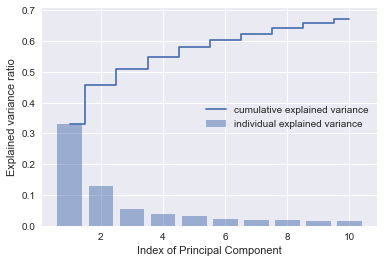

In [50]:
plt.bar(range(1,11), faces_pca.explained_variance_ratio_[0:10], alpha = 0.5, align = "center", label = "individual explained variance")
plt.step(range(1,11), cum_explained_variance_ratio_top_ten, where="mid", label = "cumulative explained variance")
plt.ylabel("Explained variance ratio")
plt.xlabel("Index of Principal Component")
plt.legend(loc = "best")
plt.show

We can also take a look at what our eigenvectors look like - here are the first 20:

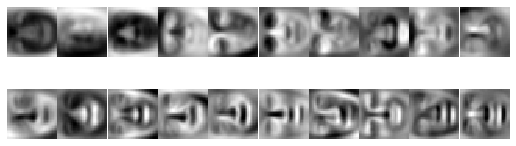

In [53]:
fig, axes = plt.subplots(2,10,figsize=(9,3), subplot_kw={"xticks":[], "yticks":[]}, gridspec_kw=dict(hspace=0.01, wspace=0.01))
for i, ax in enumerate(axes.flat):
    ax.imshow(faces_pca.components_[i].reshape(32,32),cmap="gray")

As before, we can use these eigenvectors to reconstruct any of the faces on the dataset, based on the reduced-dimensional representation. With `scikitlearn`, we do this by running `transform()` on the PCA object to access the eigenvectors, and then `inverse_transform()` on the eigenvectors to reconstruct the original images:

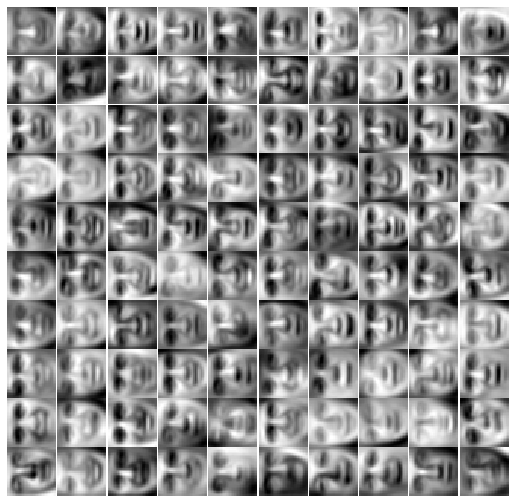

In [54]:
components = faces_pca.transform(faces)
projected = faces_pca.inverse_transform(components)
fig, axes = plt.subplots(10,10,figsize=(9,9), subplot_kw={'xticks':[], 'yticks':[]},
            gridspec_kw=dict(hspace=0.01, wspace=0.01))
for i, ax in enumerate(axes.flat):
    ax.imshow(projected[i].reshape(32,32),cmap="gray")

Because we captured 80% of the variance when we ran PCA, we can see that the images have been degraded a fair bit (20%). In practice, we'd probably want to select the set of eigenvectors that capture 95% of the variance to be a "good" sub-space - reducing dimensions but also retaining '*most*' of the information.

That wraps up what I wanted to discuss on using `scikitlearn` to do PCA. For more information, see the official docs at:
- https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA.transform

You can also find a handy blog looking at using `scikitlearn` and `pandas` to complete pca on pictures of face data here:
- https://medium.com/@sebastiannorena/pca-principal-components-analysis-applied-to-images-of-faces-d2fc2c083371

### 2.6 PCA for visualization

In the earlier K-means image compression exercise, we used the K-means algorithm in the 3-dimensional RGB space. We reduced each pixel of the RGB image to be represented by 16 clusters. In the next cell, the course has provided code to visualize the final pixel assignments in this 3D space. Each data point is colored according to the cluster it has been assigned to. You can drag your mouse on the figure to rotate and inspect this data in 3 dimensions.

<IPython.core.display.Javascript object>


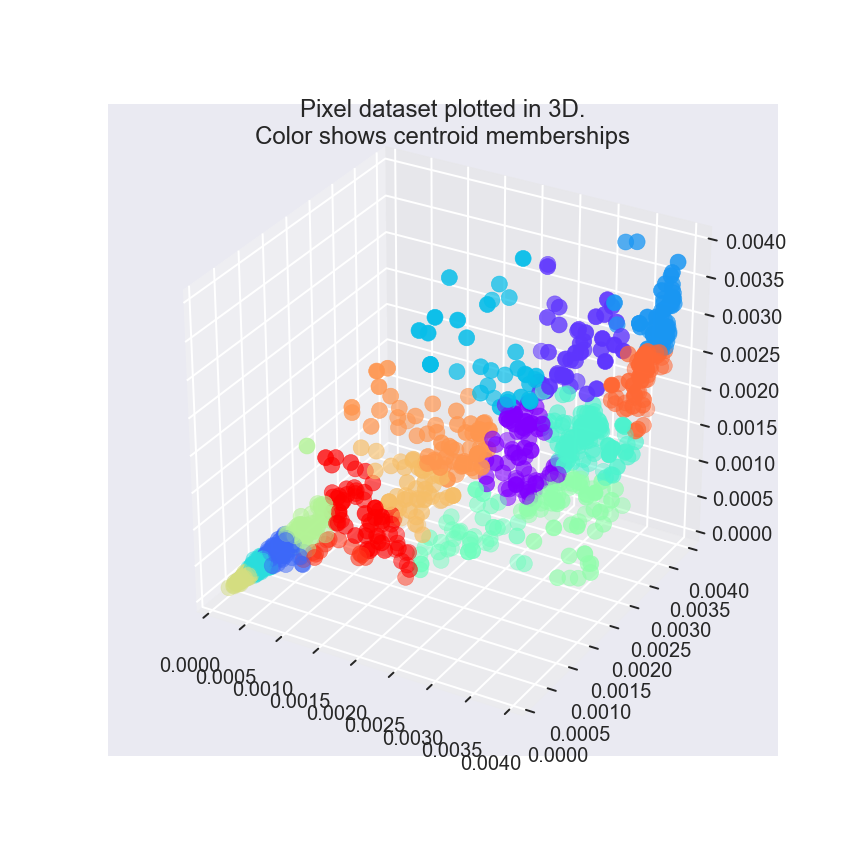

In [55]:
# this allows to have interactive plot to rotate the 3-D plot
# The double identical statement is on purpose
# see: https://stackoverflow.com/questions/43545050/using-matplotlib-notebook-after-matplotlib-inline-in-jupyter-notebook-doesnt
%matplotlib notebook
%matplotlib notebook
from matplotlib import pyplot as plt


A = mpl.image.imread(os.path.join('Data', 'bird_small.png'))
A /= 255
X = A.reshape(-1, 3)

# perform the K-means clustering again here
K = 16
max_iters = 10
initial_centroids = kMeansInitCentroids(X, K)
centroids, idx = utils.runkMeans(X, initial_centroids,
                                 findClosestCentroids,
                                 computeCentroids, max_iters)

#  Sample 1000 random indexes (since working with all the data is
#  too expensive. If you have a fast computer, you may increase this.
sel = np.random.choice(X.shape[0], size=1000)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[sel, 0], X[sel, 1], X[sel, 2], cmap='rainbow', c=idx[sel], s=8**2)
ax.set_title('Pixel dataset plotted in 3D.\nColor shows centroid memberships')
pass

It turns out that visualizing datasets in 3 dimensions or greater can be cumbersome. Therefore, it is often desirable to only display the data in 2D even at the cost of losing some information. In practice, PCA is often used to reduce the dimensionality of data for visualization purposes. 

In the next cell, we will apply our implementation of PCA to the 3-dimensional data to reduce it to 2 dimensions and visualize the result in a 2D scatter plot. The PCA projection can be thought of as a rotation that selects the view that maximizes the spread of the data, which often corresponds to the “best” view.

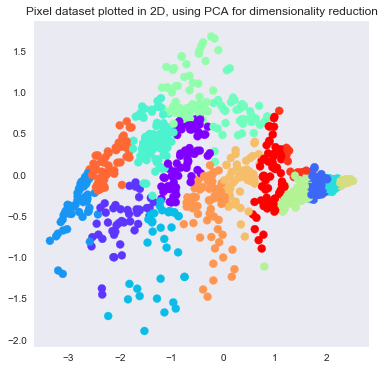

In [56]:
# Subtract the mean to use PCA
X_norm, mu, sigma = utils.featureNormalize(X)

# PCA and project the data to 2D
U, S = pca(X_norm)
Z = projectData(X_norm, U, 2)

# Reset matplotlib to non-interactive
%matplotlib inline

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

ax.scatter(Z[sel, 0], Z[sel, 1], cmap='rainbow', c=idx[sel], s=64)
ax.set_title('Pixel dataset plotted in 2D, using PCA for dimensionality reduction')
ax.grid(False)
pass

That's the end of this week's exercise. Next week we move on to detecting anomalies using machine learning techniques.